In [1]:
%matplotlib inline

import edward as ed
import numpy as np
import tensorflow as tf

from edward.models import Normal, Categorical, Multinomial, Empirical, PointMass

import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse
from keras.datasets import mnist

from tqdm import tqdm
plt.style.use('ggplot')

Using TensorFlow backend.


In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train_flatten = np.array([x.flatten() for x in x_train]) / 256
x_test_flatten = np.array([x.flatten() for x in x_test]) / 256

In [4]:
#Size of training data
N = x_train_flatten.shape[0]
K = 10

#Batch size
M = 128
H= 20
D = x_train_flatten.shape[1]

### Create batches

In [5]:
def generator(arrays, batch_size):
  """Generate batches, one with respect to each array's first axis."""
  starts = [0] * len(arrays)  # pointers to where we are in iteration
  while True:
    batches = []
    for i, array in enumerate(arrays):
      start = starts[i]
      stop = start + batch_size
      diff = stop - array.shape[0]
      if diff <= 0:
        batch = array[start:stop]
        starts[i] += batch_size
      else:
        batch = np.concatenate((array[start:], array[:diff]))
        starts[i] = diff
      batches.append(batch)
    yield batches

In [6]:
data = generator([x_train_flatten, y_train], M)

### Model

In [7]:
def variables():
    x = tf.placeholder(tf.float32, shape=[None, D])
    y = tf.placeholder(tf.int32, shape=[None])
    
    #loc is the mean and scale is the variance
    W0 = Normal(loc=tf.zeros([D, H]), scale=tf.ones([D, H]))
    W1 = Normal(loc=tf.zeros([H, H]), scale=tf.ones([H, H]))
    W2 = Normal(loc=tf.zeros([H, K]), scale=tf.ones([H, K]))
    
    b0 = Normal(loc=tf.zeros(H), scale=tf.ones(H))
    b1 = Normal(loc=tf.zeros(H), scale=tf.ones(H))
    b2 = Normal(loc=tf.zeros(K), scale=tf.ones(K))
    
    return ({'x': x, 'y': y, 'W0': W0, 'b0':b0,'W1': W1, 'b1':b1, 'W2': W2, 'b2': b2})

def model(variables, mask):
    x = variables['x']
    
    #layer 1
    x = tf.matmul(x, tf.multiply(variables['W0'], mask['W0'])) + tf.multiply(variables['b0'], mask['b0'])
    x = tf.tanh(x)
    
    #layer 2
    x = tf.matmul(x, variables['W1']) + variables['b1']
    x = tf.nn.tanh(x)
    
    #layer 3
    x = tf.matmul(x, variables['W2']) + variables['b2']
    logits = x
    
    output = Categorical(logits)
    
    return output

def approximation_variables():
    qW0 = Normal(loc=tf.Variable(tf.random_normal([D, H])),
                  scale=tf.nn.softplus(tf.Variable(tf.random_normal([D, H]))))
    qW1 = Normal(loc=tf.Variable(tf.random_normal([H, H])),
                  scale=tf.nn.softplus(tf.Variable(tf.random_normal([H, H]))))
    qW2 = Normal(loc=tf.Variable(tf.random_normal([H, K])),
                  scale=tf.nn.softplus(tf.Variable(tf.random_normal([H, K]))))
    qb0 = Normal(loc=tf.Variable(tf.random_normal([H])),
                  scale=tf.nn.softplus(tf.Variable(tf.random_normal([H]))))
    qb1 = Normal(loc=tf.Variable(tf.random_normal([H])),
                  scale=tf.nn.softplus(tf.Variable(tf.random_normal([H]))))
    qb2 = Normal(loc=tf.Variable(tf.random_normal([K])),
                  scale=tf.nn.softplus(tf.Variable(tf.random_normal([K]))))
    variables = {'W0': qW0, 'W1': qW1, 'W2': qW2,
                 'b0': qb0, 'b1': qb1, 'b2': qb2}
    return variables

mask = {'W0':tf.ones([D, H]), 'b0':tf.ones([H])}
variables = variables()
output = model(variables, mask)
q_variables = approximation_variables()

inference_dict = {variables[key]: val for key, val in q_variables.items()}
inference = ed.KLqp(inference_dict, data={output:variables['y']})

n_batch = int(N / M)
n_epoch = 5

inference.initialize(n_iter=n_batch*n_epoch, n_samples=10,
                     scale={output: n_batch})
tf.global_variables_initializer().run()
for _ in range(inference.n_iter):
    X_batch, y_batch = next(data)
    for _ in range(5):
        info_dict = inference.update(feed_dict={variables['x']: X_batch, variables['y']: y_batch})
    print('Loss: ',info_dict,  end="\r", flush=True)


## Evaluation

In [8]:
n_samples = 30
prob_lst = []
#Make sample models drawn from posterior
samples_lst = []
for _ in tqdm(range(n_samples)):
    cur_approx = {key: q_variables[key].sample()
                      if key in q_variables else variables[key]
                      for key in variables}
    #samples_lst.append(cur_approx)
    probs = tf.nn.softmax(model(cur_approx).logits)
    np_probs = probs.eval(feed_dict={cur_approx['x']: x_test_flatten})
    prob_lst.append(np_probs)


100%|██████████| 30/30 [00:03<00:00,  8.19it/s]


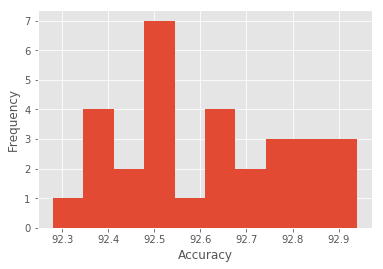

In [9]:
accy_test = []
for prob in prob_lst:
    y_trn_prd = np.argmax(prob,axis=1).astype(np.float32)
    acc = (y_trn_prd == y_test).mean()*100
    accy_test.append(acc)

plt.hist(accy_test)
plt.xlabel("Accuracy")
plt.ylabel("Frequency")
plt.show()

In [10]:
#Model Averaging
y_pred = np.argmax(np.mean(prob_lst,axis=0),axis=1)
print(" Accuracy on test set= ", (y_pred == y_test).mean()*100)

 Accuracy on test set=  94.4


## Uncertainty in Predictions

truth =  7


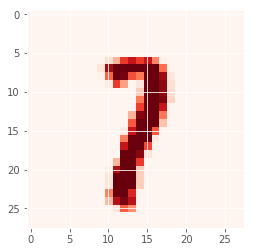

In [11]:
test_ind = 111
test_image = x_test_flatten[test_ind]
test_label = y_test[test_ind]
print('truth = ',test_label)
pixels = test_image.reshape((28, 28))
plt.imshow(pixels, cmap='Reds')

In [12]:
img_probs = []
for prob in prob_lst:
    y_trn_prd = np.argmax(prob,axis=1).astype(np.float32)
    acc = y_trn_prd[test_ind]
    img_probs.append(acc)

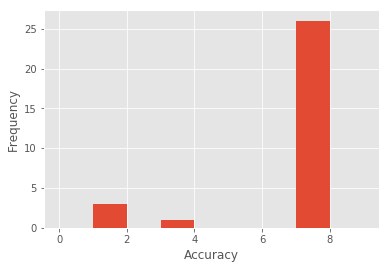

In [13]:
plt.hist((img_probs),bins=range(10))
plt.xlabel("Accuracy")
plt.ylabel("Frequency")
plt.show()